In [41]:
from wavelet_texture_segmentation.feature_extraction import feature_extractor
from distance_regularized_level_set_evolution.find_lsf import find_lsf

import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure

In [42]:
def plot_features(features):
    for i in range(features.shape[3]):
        for j in range(features.shape[2]):
            plt.subplot(features.shape[3],features.shape[2],(i*features.shape[2])+j+1)
            plt.imshow(features[:,:,j,i])
    plt.show()

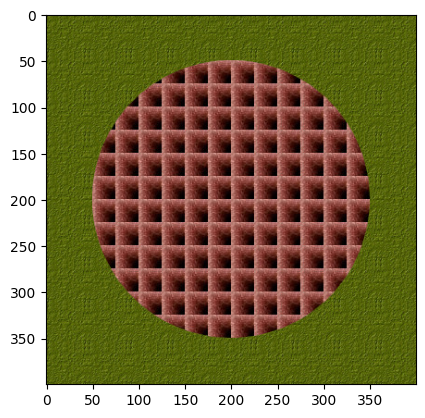

In [43]:
image_path = "samples/texture5.jpg"

image = cv2.imread(image_path)
# image = cv2.resize(image, (300,400))

plt.imshow(image)
plt.show()

In [44]:
import pickle
filename = f"data/extractor_{image_path[image_path.rindex('/')+1:image_path.rindex('.')]}.pkl"

feature_methods = ["contrast", "cluster prominence", "cluster shade", "energy", "dissimilarity", "homogeneity", "ASM", "correlation"]
extractor = feature_extractor(image, 27, feature_methods=feature_methods, comatrix_level=32)

# with open(filename, 'rb') as file:
#     extractor = pickle.load(file)

Extracting texture features, this can take a while


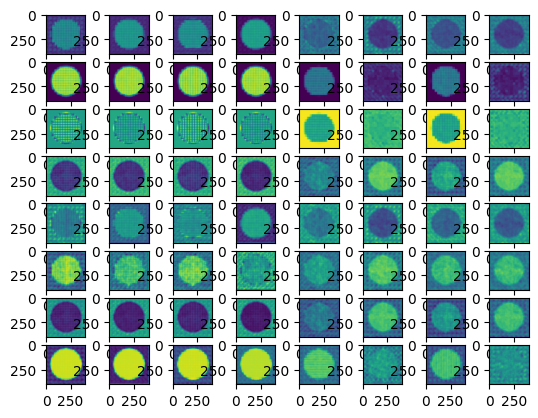

In [45]:
texture_features = extractor.get_texture_features()

plot_features(texture_features)

In [47]:
from wavelet_texture_segmentation.utils import normalize
for i in range(texture_features.shape[2]):
    for j in range(texture_features.shape[3]):
        cv2.imwrite(f"texture5_{i}_{feature_methods[j]}.jpg", cv2.resize(normalize(texture_features[:,:,i,j]), (300,300), interpolation=cv2.INTER_NEAREST) * 255)

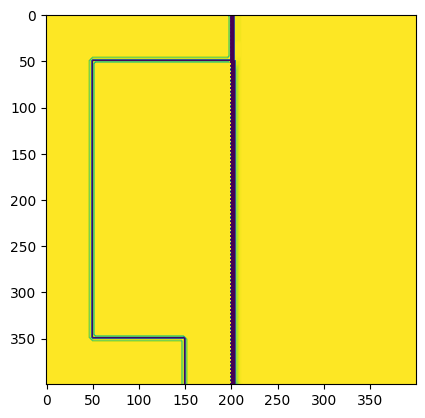

In [10]:
g_combined = extractor.get_combined_edges()

plt.imshow(g_combined)
plt.show()

In [37]:
with open(filename, 'wb') as file:
    pickle.dump(extractor, file)

In [11]:
c0 = 2
initial_lsf = c0 * np.ones_like(g_combined)
initial_lsf[10:-10, 10:-10] = -c0

In [12]:
iteration = 0
phi = initial_lsf.copy()
last_title = ""
cv2.imshow(last_title, image)

while True:
    phi = find_lsf(
        g=g_combined, # g_modified * (g_modified > tresh)
        initial_lsf=phi,
        timestep=5,
        iter_inner=20,
        iter_outer=1,
        lmda=50,
        alfa=3,
        epsilon=1.5)
    iteration += 1
    
    contours = measure.find_contours(phi, 0)

    contour_image = image.copy()
    cv_contours = []
    for contour in contours:
        cv_contour = np.array([[int(point[1]), int(point[0])] for point in contour], dtype=np.int32)
        cv_contours.append(cv_contour)
    cv2.drawContours(contour_image, cv_contours, -1, (0, 0, 255), 2)

    if not cv2.getWindowProperty(last_title, cv2.WND_PROP_VISIBLE): break # Stop when window was closed

    cv2.imshow(last_title, contour_image)

    new_title = f"DRLSE iteration {iteration}"
    cv2.setWindowTitle(last_title, new_title)
    last_tile = new_title

    if cv2.waitKey(1) != -1: break # Stop when key was pressed
cv2.destroyAllWindows()

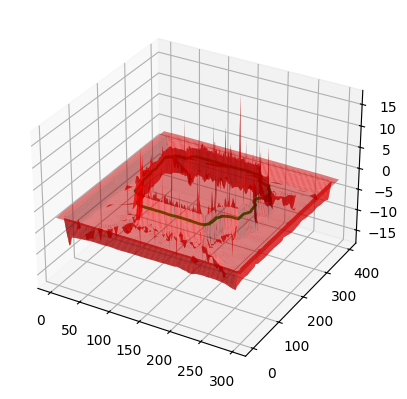

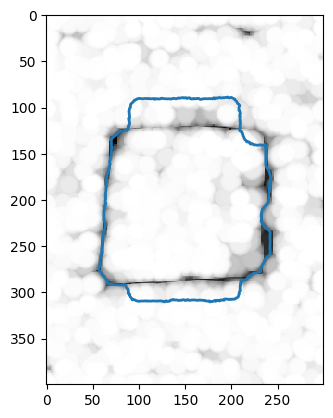

In [55]:
plt.ion()
fig1 = plt.figure(1)
fig2 = plt.figure(2)


fig1.clf()
ax1 = fig1.add_subplot(111, projection='3d')
y, x = phi.shape
x = np.arange(0, x, 1)
y = np.arange(0, y, 1)
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, -phi, rstride=2, cstride=2, color='r', linewidth=0, alpha=0.6, antialiased=True)
ax1.contour(X, Y, phi, 0, colors='g', linewidths=2)

fig2.clf()
contours = measure.find_contours(phi, 0)

ax2 = fig2.add_subplot(111)
ax2.imshow(image, interpolation='nearest', cmap=plt.get_cmap('gray'))
for contour in contours:
    ax2.plot(contour[:, 1], contour[:, 0], linewidth=2)